# Skin Cancer Classification
- The dataset you will use contains images of malignant and benign oncological diseases. 
- Number of Classes = 3:
  - **Actinic Keratosis:** Dry scaly patches of skin that have been damaged by the sun.
  -  **Basal Cell Carcinoma:** The most common form of skin cancer it begins in the basal cells.
  - **Melanoma:** The most serious type of skin cancer, develops in the cells (melanocytes) that produce melanin — the pigment that gives your skin its color.


## Imports

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from PIL import Image

## Download Data

In [35]:
# !pip install --upgrade --no-cache-dir gdown

In [36]:
# !gdown "https://drive.google.com/uc?id=1Hyojd3qHkNg3nI7-EbOZiZHRss3C-HI8"

In [37]:
# !unzip /kaggle/working/Data.zip

## Visualize Images

In [38]:
actinic_keratosis = Image.open("/kaggle/working/Data/Test/actinic-keratosis/ISIC_0024511.jpg")
basal_cell_carcinoma = Image.open("/kaggle/working/Data/Test/basal-cell-carcinoma/ISIC_0024448.jpg")
melanoma = Image.open("/kaggle/working/Data/Test/melanoma/ISIC_0000054.jpg")

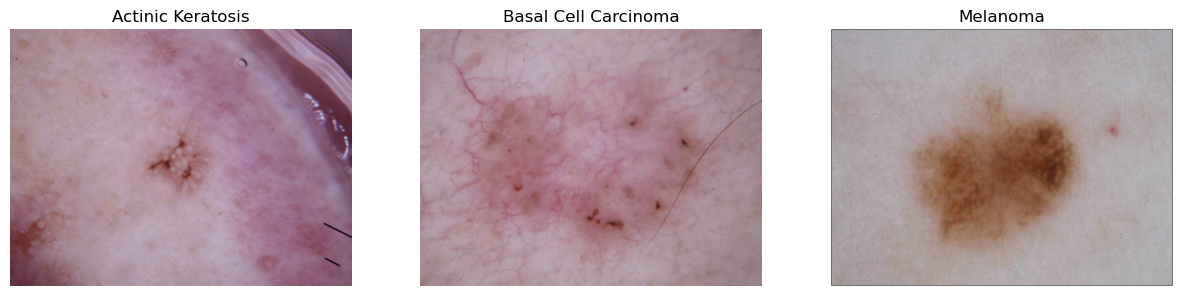

In [39]:
plt.figure(figsize=(15, 15))
i = 0
class_names = ["Actinic Keratosis","Basal Cell Carcinoma","Melanoma"]
images = [actinic_keratosis,basal_cell_carcinoma,melanoma]
for item in images:
  ax = plt.subplot(1, 3, i+1)
  plt.imshow(item)
  plt.title(class_names[i])
  plt.axis("off")
  i+=1

## Generate a train and test dataloader from the images files in the directory:
 - define the batch size to: 16
 - define image size to be: 224,224
 - hint: use image_dataset_from_directory method

In [40]:
# Your code here
train_dir ="/kaggle/working/Data/Train" 
validation_dir = "/kaggle/working/Data/Test" 

In [41]:
#Size of the batches of data
BATCH_SIZE = 16
#Size to resize images
IMG_SIZE = (244, 244)

In [42]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 928 files belonging to 3 classes.


In [43]:
test_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 48 files belonging to 3 classes.


## Split the train dataloader into train and validation
- **train:** 54 batches
- **valid:** 4 batches 

In [44]:
# Your code here
train_dataset = train_dataset.skip(4)
validation_dataset = train_dataset.take(4)

## Define an augmentation Layer 
 - Use ```RandomFlip``` layer and set it to ```horizontal_and_vertical```
 - Use ```RandomRotation``` layer and set it to ```0.2```
 - Use ```RandomZoom``` layer and set it to ```0.2```


In [45]:
# Your code here
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])

## Define a layer to use the same preprocessing as the pretrained model ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16)):


In [46]:
# Your code here
preprocess_input = tf.keras.applications.vgg16.preprocess_input

## Download the pretrained model
- Don't forget to not include the classification layer

In [47]:
# Your code here
IMG_SHAPE = (244,244,3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False, # load the model without the classification layers at the top
                                               weights='imagenet')

## Un-Freeze the top layers of the model

In [48]:
# Your code here
base_model.trainable = True

In [49]:
# The base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [50]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [51]:
# Fine-tune from this layer onwards
fine_tune_at = 14

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Create a Flatten layer to convert the feature map to 1D vector

In [52]:
# Your code here
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

## Create a dropout layer

In [53]:
# Your code here
x = tf.keras.layers.Dropout(0.2)

## Create a Predication Layer
 [Dense Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
 - Set the number of units = 3 as you have 3 classes. 
 - The activation function softmax.


In [54]:
# Your Code here
prediction_layer = tf.keras.layers.Dense(3,"softmax")

## Chain the layers to build the model

In [55]:
# Your code here
inputs = tf.keras.Input(shape=(244, 244, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x) # flatten 1-D vector
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model
- Use [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function.
- Use [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) as the optimizer with ```0.0001``` learning rate.
- Use ```Accuracy``` as the metric for evaluation.

In [56]:
# Your Code here
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 244, 244, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 244, 244, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

## Train the model
- Number of epochs =  ```5```

In [58]:
# Your code here
epochs = 5

In [59]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/5
54/54 [==============================] - 14s 170ms/step - loss: 0.6653 - accuracy: 0.7535 - val_loss: 0.4172 - val_accuracy: 0.8125
Epoch 2/5
54/54 [==============================] - 11s 165ms/step - loss: 0.4128 - accuracy: 0.8345 - val_loss: 0.3501 - val_accuracy: 0.8594
Epoch 3/5
54/54 [==============================] - 10s 164ms/step - loss: 0.2581 - accuracy: 0.9028 - val_loss: 0.2259 - val_accuracy: 0.9219
Epoch 4/5
54/54 [==============================] - 10s 165ms/step - loss: 0.2126 - accuracy: 0.9213 - val_loss: 0.2015 - val_accuracy: 0.9375
Epoch 5/5
54/54 [==============================] - 10s 174ms/step - loss: 0.1728 - accuracy: 0.9398 - val_loss: 0.1927 - val_accuracy: 0.9375


## Evaluate the model on test set

In [60]:
# Your code here
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 44ms/step - loss: 1.7924 - accuracy: 0.8333
Test accuracy : 0.8333333134651184
